# Download and prepare data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path):
  return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# read a file and split into lines
def readlines(filename):
  with open(filename, encoding='utf-8') as some_file:
    return [unicodeToAscii(line.strip()) for line in some_file]

category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readlines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
  raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
  
print('# categories', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories 18 ['Polish', 'German', 'Czech', 'Scottish', 'Japanese', 'Italian', 'Chinese', 'Russian', 'Portuguese', 'Irish', 'Dutch', 'Vietnamese', 'Arabic', 'Korean', 'English', 'French', 'Spanish', 'Greek']
O'Neal


# Network

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    
  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = F.log_softmax(output, dim=1)
    return output, hidden

# Training

In [6]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  return category, line

In [7]:
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor

def inputTensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

def targetTensor(line):
  letters_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  letters_indexes.append(n_letters - 1)
  return torch.LongTensor(letters_indexes)

In [8]:
def randomTrainingExample():
  category, line = randomTrainingPair()
  category_tensor = categoryTensor(category)
  input_line_tensor = inputTensor(line)
  target_line_tensor = targetTensor(line)
  return category_tensor, input_line_tensor, target_line_tensor

In [9]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
  target_line_tensor.unsqueeze_(-1)
  hidden = rnn.init_hidden()

  rnn.zero_grad()
  loss = 0

  for i in range(input_line_tensor.size(0)):
    output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
    l = criterion(output, target_line_tensor[i])
    loss += l

  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)
  
  return output, loss.item() / input_line_tensor.size(0)

In [10]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 11s (5000 5%) 2.5271
0m 27s (10000 10%) 2.6130
0m 38s (15000 15%) 1.9623
0m 51s (20000 20%) 2.5263
1m 4s (25000 25%) 2.1903
1m 19s (30000 30%) 2.1732
1m 33s (35000 35%) 2.0141
1m 47s (40000 40%) 3.1498
2m 1s (45000 45%) 2.0651
2m 17s (50000 50%) 3.0846
2m 33s (55000 55%) 1.9936
2m 47s (60000 60%) 2.6894
3m 3s (65000 65%) 2.1189
3m 18s (70000 70%) 2.5978
3m 32s (75000 75%) 1.5871
3m 46s (80000 80%) 2.2028
4m 0s (85000 85%) 2.1679
4m 14s (90000 90%) 2.2588
4m 28s (95000 95%) 2.3320
4m 42s (100000 100%) 3.5396


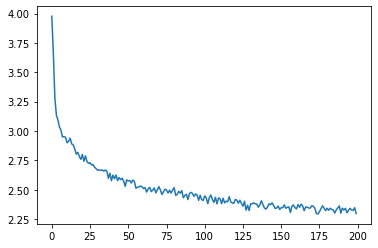

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

# Sampling the network

In [15]:
max_length = 20
def sample(category, start_letter='A'):
  with torch.no_grad():
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = rnn.init_hidden()

    output_name = start_letter

    for i in range(max_length):
      output, hidden = rnn(category_tensor, input[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == n_letters - 1:
        break
      else:
        letter = all_letters[topi]
        output_name += letter
      input = inputTensor(letter)

  return output_name

def samples(category, start_letters='ABC'):
  for start_letter in start_letters:
    print(sample(category, start_letter))

In [16]:
samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rakovakov
Uanovovovovovov
Shanovovovov
Gerter
Eren
Ronerr
Santer
Parera
Ales
Chan
Han
Iun
